In [21]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")


# Training data preparation 

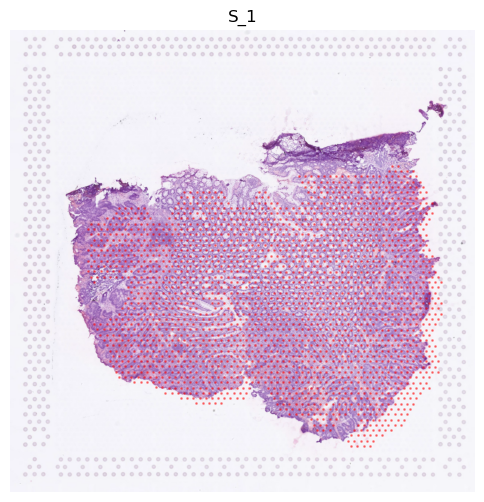

In [220]:
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]
    
    sample = 'S_1'
    image = np.array(train_images[sample])
    spots = np.array(train_spots[sample])
    x, y = spots["x"], spots["y"]
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

## Tiles

In [111]:
def extract_tile(slide_img, x, y, tile_size=224):
    half = tile_size // 2
    x1, x2 = x - half, x + half
    y1, y2 = y - half, y + half
    tile = slide_img[y1:y2, x1:x2]  # shape: (224, 224, 3)
    return tile
def get_spots_in_tile(df, center_x, center_y, tile_size):
    half = tile_size // 2
    x_min, x_max = center_x - half, center_x + half
    y_min, y_max = center_y - half, center_y + half

    df_in_tile = df[
        (df['x'] >= x_min) & (df['x'] <= x_max) &
        (df['y'] >= y_min) & (df['y'] <= y_max)
    ].copy()

    df_in_tile = df_in_tile[
        ~((df_in_tile['x'] == center_x) & (df_in_tile['y'] == center_y))
    ]

    return df_in_tile


import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_tile_with_spots(
    slide_image, spot_df, center_x, center_y,
    tile_size=78, stride=None, grid_size=None,
    spot_radius_px=15
):
    """
    可視化一個 tile，包含中心 spot、鄰近 spot，以及可選的 N×N 子區格線。

    Parameters:
    - slide_image: 該張切片的影像 (numpy array, H x W x 3)
    - spot_df: 包含所有落在 tile 內的 spots（已排除中心點）
    - center_x, center_y: 中心 spot 的 slide 座標
    - tile_size: 單一 tile 的大小（像素）
    - stride: tile 間距（默認等於 tile_size，表示無重疊）
    - grid_size: 幾乘幾的 tile（如果 None，就只畫單 tile）
    - spot_radius_px: 中心 spot 畫圓半徑
    """

    if stride is None:
        stride = tile_size

    if grid_size:
        full_tile_size = tile_size + stride * (grid_size - 1)
    else:
        full_tile_size = tile_size

    center_color = 'red'
    neighbor_color = 'orange'
    show_legend = True
    title = f"{len(spot_df)} neighbors in tile"

    # 擷取 tile
    def extract_tile(slide_img, x, y, total_size):
        x, y = int(x), int(y)
        half = total_size // 2
        x1, x2 = x - half, x + half
        y1, y2 = y - half, y + half
        tile = slide_img[y1:y2, x1:x2]
        return tile

    tile = extract_tile(slide_image, center_x, center_y, full_tile_size)

    # 畫圖
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(tile)

    # 畫格線
    # 畫出每個 tile 的實際切割框
    if grid_size:
        for row in range(grid_size):
            for col in range(grid_size):
                x0 = col * stride
                y0 = row * stride
                rect = patches.Rectangle(
                    (x0, y0),
                    tile_size, tile_size,
                    linewidth=1,
                    edgecolor='blue',
                    facecolor='none',
                    linestyle='--'
                )
                ax.add_patch(rect)


    # 中心 spot（固定畫在 tile 中央）
    center_px = full_tile_size // 2
    ax.scatter(center_px, center_px, c=center_color, s=40, label='Center Spot')

    # 中心 spot 圓圈
    circle = patches.Circle(
        (center_px, center_px),
        spot_radius_px,
        linewidth=1.5,
        edgecolor='yellow',
        facecolor='none'
    )
    ax.add_patch(circle)

    # 鄰居 spots（轉成 tile 內相對座標）
    for _, neighbor in spot_df.iterrows():
        dx = int(neighbor['x']) - center_x
        dy = int(neighbor['y']) - center_y
        tile_x = center_px + dx
        tile_y = center_px + dy
        ax.scatter(tile_x, tile_y, c=neighbor_color, s=20)

    ax.axis('off')
    if show_legend:
        ax.legend(loc='upper right')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


## calculate tile_size

In [232]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

train_spacing_per_slide = {}

for slide_id, df in train_spot_tables.items():
    coords = df[['x', 'y']].values
    if len(coords) < 2:
        print(f"⚠️ Slide {slide_id} has less than 2 spots, skipping.")
        continue

    dist_matrix = squareform(pdist(coords))
    np.fill_diagonal(dist_matrix, np.inf)
    min_dists = dist_matrix.min(axis=1)
    mean_spacing = min_dists.mean()

    train_spacing_per_slide[slide_id] = mean_spacing
    print(f"📏 {slide_id}: 平均 spot 間距 = {mean_spacing:.2f} pixels")




📏 S_1: 平均 spot 間距 = 25.90 pixels
📏 S_2: 平均 spot 間距 = 25.95 pixels
📏 S_3: 平均 spot 間距 = 25.20 pixels
📏 S_4: 平均 spot 間距 = 25.02 pixels
📏 S_5: 平均 spot 間距 = 25.01 pixels
📏 S_6: 平均 spot 間距 = 25.24 pixels


## Start tiling

### Just cut

In [ ]:
from sklearn.preprocessing import MinMaxScaler
with h5py.File("./dataset/gu_smooth_processed_train_spots.h5", "r") as f:
    train_spots = f["spots/log2_Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df
# ======= 資料儲存區 =======

train_M_tiles = []
train_labels = []
normal_coords = []
coords = []

# ======= 主迴圈 =======
#with h5py.File("./dataset/filtered&masked_dataset.h5", "r") as h5file:

with h5py.File("./dataset/combined_slide_images_with_mask.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    slide_ids = list(train_spot_tables.keys())

    for slide_id in slide_ids:
        if slide_id not in train_images:
            print(f"⚠️ Slide {slide_id} not found in HDF5, skipping.")
            continue

        image = train_images[slide_id][()]  # H x W x 3
        df = train_spot_tables[slide_id]

        # Step 4: 標準化座標
        ext_coords = df[['x', 'y']].values
        scaler = MinMaxScaler()
        coords_normalized = scaler.fit_transform(ext_coords)
        df[['x_normalized', 'y_normalized']] = coords_normalized

        for i, row in df.iterrows():
            x, y = int(row['x']), int(row['y'])
            nx, ny = row['x_normalized'], row['y_normalized']

            # 擷取 tile
            train_M_tile = extract_tile(image, x, y, tile_size=112)
            label = row.iloc[2:-2].values.astype(np.float32)

            # 儲存
            train_M_tiles.append(train_M_tile)
            train_labels.append(label)
            coords.append((x, y))
            normal_coords.append((nx, ny))

### Augmentation

In [ ]:
import albumentations as A

augment_transform = A.ReplayCompose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
], p=1.0)

N = 3
aug_M_tiles = []
aug_labels = []
aug_coords = []
aug_normal_coords = []

for  m_tile, label, coord, norm_coord in zip(
        train_M_tiles,
        train_labels, coords, normal_coords):
    
    for _ in range(N):
        # 對主圖 s_tile 先做一次 transform 並記錄 replay
        transformed = augment_transform(image=m_tile)
        aug_m = transformed['image']

        # 用完全一樣的 augmentation 參數重播到 m_tile, l_tile
        # shape 現在完全正確
        aug_M_tiles.append(aug_m)
        aug_labels.append(label)
        aug_coords.append(coord)
        aug_normal_coords.append(norm_coord)


In [ ]:
import matplotlib.pyplot as plt
import random

def show_augmented_triplet( m_tile1, m_tile2, m_tile3, title="Augmented M"):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(m_tile1.astype('float32'))
    plt.title("S Tile")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(m_tile2.astype('float32') )
    plt.title("M Tile")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(m_tile3.astype('float32'))
    plt.title("L Tile")
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# ✅ 正確從 augmentation list 抓一組
idx = random.randint(0, len(aug_M_tiles) - 1)
show_augmented_triplet(aug_M_tiles[idx-1], aug_M_tiles[idx], aug_M_tiles[idx+1])


NameError: name 'aug_S_tiles' is not defined

In [ ]:

all_M_tiles = train_M_tiles + aug_M_tiles

# 合併 labels & metadata
all_labels = train_labels + aug_labels
all_coords = coords + aug_coords
all_normal_coords = normal_coords + aug_normal_coords


## Transfer into training dataset 

In [9]:
## Make sure I have all the data
total_spots = sum(len(df) for df in train_spot_tables.values())
print(f"Total number of spots across all slides: {total_spots}")

print(f"The spots in our preprocessing datasets: {len(train_M_tiles)}")

Total number of spots across all slides: 8181
The spots in our preprocessing datasets: 8181


In [ ]:
import torch
import os

output_dir = "./dataset/final_data/"
os.makedirs(output_dir, exist_ok=True)

# 轉換成 tensor（可選擇是否轉換）
torch.save(all_M_tiles, os.path.join(output_dir, "M_tiles.pt"))
torch.save(all_labels, os.path.join(output_dir, "gu_log2_labels.pt"))
torch.save({
    "coords": all_coords,
    "normalized_coords": all_normal_coords
}, os.path.join(output_dir, "meta_info.pt"))

print("✅ 所有資料已成功儲存到 final_data 資料夾！")


✅ 所有資料已成功儲存到 final_data 資料夾！


# Test data preparation

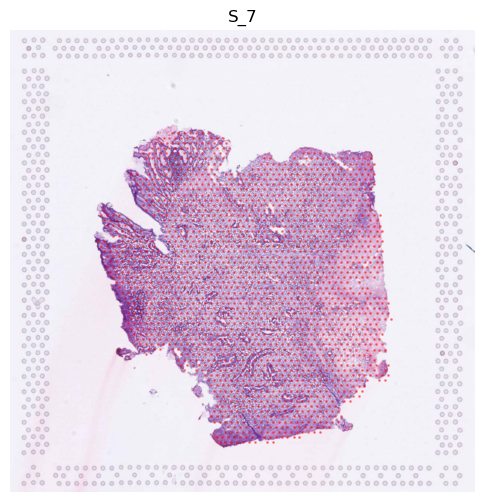

In [7]:
# Visualize Test slide ('S_7')
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    test_images = h5file["images/Test"]
    test_spots = h5file["spots/Test"]
    
    sample = 'S_7'
    image = np.array(test_images[sample])
    spots = np.array(test_spots[sample])
    x, y = spots["x"], spots["y"]

    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [8]:
# Display spot table for Test slide (only the spot coordinates on 2D array)
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    print(test_spots.keys())
    spot_array = np.array(test_spots['S_7'])
    test_spot_table = pd.DataFrame(spot_array)
    
# Show the test spots coordinates for slide 'S_7'
test_spot_table

<KeysViewHDF5 ['S_7']>


,x,y,Test_Set
0,1499,1260,2
1,1435,1503,2
2,558,1082,2
3,736,1304,1
4,1257,1592,1
...,...,...,...
2083,736,639,2
2084,1016,684,2
2085,1181,839,2
2086,735,1436,1


Found 17 spots in this tile.


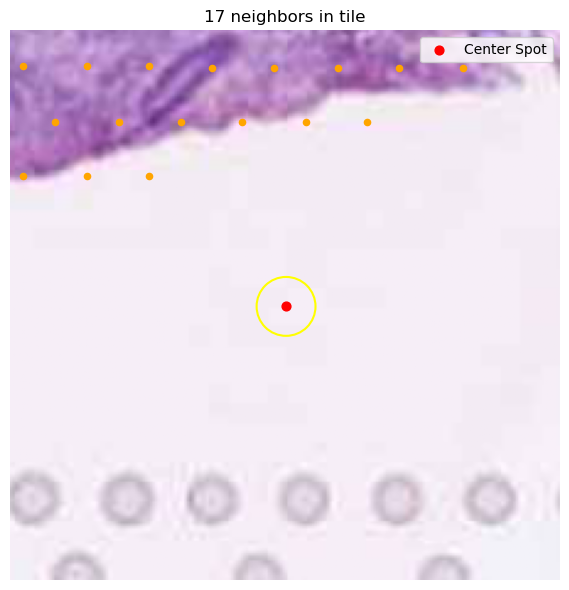

In [215]:
import random

# 隨機抽一筆資料（從全體 tiles 中）

i = random.randint(0, len(test_spot_table) - 1)

row = test_spot_table.iloc[i]

x = 1300
y = 1800

# 取得tile範圍內的spot們
neighbors_df = get_spots_in_tile(test_spot_table, x, y, tile_size=224)

print(f"Found {len(neighbors_df)} spots in this tile.")
#print(neighbors_df[['x', 'y']])
##print(x,y)
plot_tile_with_spots(
    slide_image=image,
    spot_df=neighbors_df,
    center_x=x,
    center_y=y,
    tile_size=224,
    #grid_size=3,
    spot_radius_px=12
)


In [26]:
coords = test_spot_table[['x', 'y']].values
# 計算距離矩陣（所有 spot 之間）
dist_matrix = squareform(pdist(coords))  # shape = (N, N)

# 把對角線設為無限大（自己對自己不算）
np.fill_diagonal(dist_matrix, np.inf)

# 取得每個 spot 最近的一個鄰居距離
min_dists = dist_matrix.min(axis=1)

# 算平均距離
mean_spacing = min_dists.mean()

print(f"平均每個 spot 間距：約 {mean_spacing:.2f} pixels")

平均每個 spot 間距：約 25.01 pixels


0.8490186


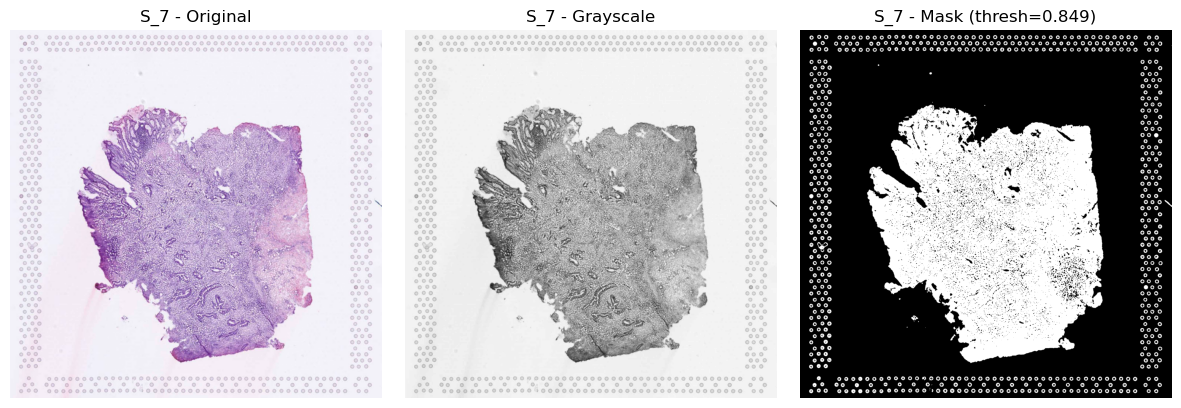

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
custom_thresholds = {
    
}
slide_masks = {}
slide_thresholds = {}
slide ={}
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Test"]
    slide_ids = list(train_images.keys())

    n = len(slide_ids)
    fig, axs = plt.subplots(nrows=n, ncols=3, figsize=(12, 4 * n))
    if n == 1:
        axs = [axs]

    for i, slide_id in enumerate(slide_ids):
        image = np.array(train_images[slide_id])
        gray_image = rgb2gray(image)

        # ✅ 使用自訂 threshold（如果沒有就 fallback）
        thresh = custom_thresholds.get(slide_id, threshold_mean(gray_image))
        binary_mask = (gray_image > thresh).astype(np.uint8)
        binary_mask = 1 - binary_mask
        print(thresh)
        slide[slide_id] = image
        slide_masks[slide_id] = binary_mask
        slide_thresholds[slide_id] = thresh

        axs[i][0].imshow(image)
        axs[i][0].set_title(f"{slide_id} - Original")
        axs[i][0].axis("off")

        axs[i][1].imshow(gray_image, cmap="gray")
        axs[i][1].set_title(f"{slide_id} - Grayscale")
        axs[i][1].axis("off")

        axs[i][2].imshow(binary_mask, cmap="gray")
        axs[i][2].set_title(f"{slide_id} - Mask (thresh={thresh:.3f})")
        axs[i][2].axis("off")

    plt.tight_layout()
    plt.show()



✔️ 合併完成: S_7 → shape (1983, 2000, 4)


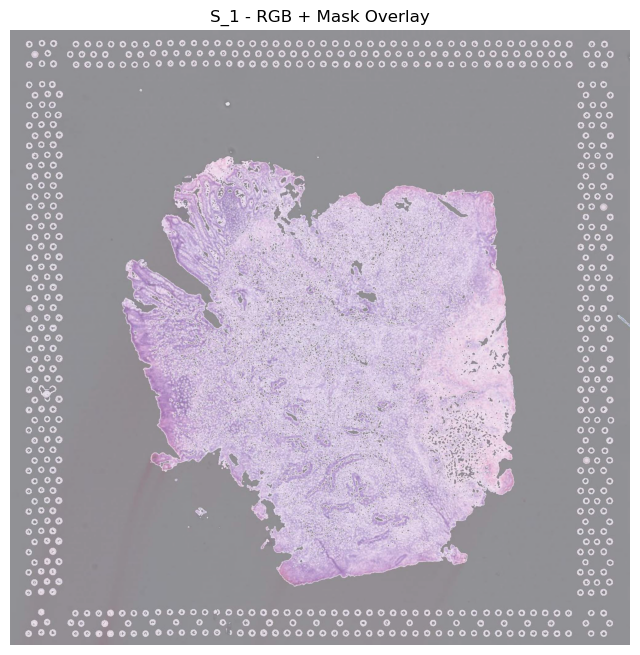

In [16]:
combined_slide_images = {}  # slide_id -> (H, W, 4)

for slide_id in slide.keys():
    image = slide[slide_id]                  # shape: (H, W, 3)
    mask = slide_masks[slide_id]         # shape: (H, W)

    # ✅ 先把 mask 加一個通道軸，變成 (H, W, 1)
    mask = np.expand_dims(mask, axis=-1)

    # ✅ 合併成 (H, W, 4)
    combined = np.concatenate([image, mask], axis=-1)  # 如果想讓 mask 是 0/255 表示可視化

    combined_slide_images[slide_id] = combined
    print(f"✔️ 合併完成: {slide_id} → shape {combined.shape}")
plt.figure(figsize=(8, 8))
plt.imshow(combined_slide_images['S_7'][:, :, :3])  # RGB
plt.imshow(combined_slide_images['S_7'][:, :, 3], cmap='gray', alpha=0.4)  # Mask 疊加
plt.title("S_1 - RGB + Mask Overlay")
plt.axis('off')
plt.show()


In [17]:
import h5py
import numpy as np

output_path = "./dataset/combined_slide_images_with_mask_test.h5"

with h5py.File(output_path, "w") as f:
    image_group = f.create_group("images/Test")

    for slide_id, combined_img in combined_slide_images.items():
        image_group.create_dataset(slide_id, data=combined_img)
        print(f"✔️ 已儲存 {slide_id} → shape {combined_img.shape}")

print(f"\n✅ 所有圖像+mask 已儲存到：{output_path}")


✔️ 已儲存 S_7 → shape (1983, 2000, 4)

✅ 所有圖像+mask 已儲存到：./dataset/combined_slide_images_with_mask_test.h5


In [18]:

test_S_tiles = []
test_M_tiles = []
test_L_tiles = []
normal_coords = []
coords = []

with h5py.File("./dataset/combined_slide_images_with_mask_test.h5", "r") as h5file:
    test_images = h5file["images/Test"]
    
    slide_ids = list(test_images.keys())  # e.g., only ['S_7']
    # Step 4: 標準化座標
    df = test_spot_table

    ext_coords = df[['x', 'y']].values
    scaler = MinMaxScaler()
    coords_normalized = scaler.fit_transform(ext_coords)
    df[['x_normalized', 'y_normalized']] = coords_normalized
    
    for slide_id in slide_ids:
        image = test_images[slide_id][()]  # 讀出唯一一張 test image

        for i, row in df.iterrows():
            x, y = int(row['x']), int(row['y'])
            nx, ny = row['x_normalized'], row['y_normalized']

            # 擷取 tile
            test_S_tile = extract_tile(image, x, y, tile_size=32)
            test_M_tile = extract_tile(image, x, y, tile_size=112)
            test_L_tile = extract_tile(image, x, y, tile_size=224)
            label = row.iloc[2:-2].values.astype(np.float32)

            # 儲存
            #test_S_tiles.append(test_S_tile)
            test_M_tiles.append(test_M_tile)
            #test_L_tiles.append(test_L_tile)
            coords.append((x, y))
            normal_coords.append((nx, ny))


In [20]:

import torch
import os
output_dir = "./dataset/final_data/"
os.makedirs(output_dir, exist_ok=True)

torch.save({
    'M_tiles': test_M_tiles,
    "coords": coords,
    "normalized_coords": normal_coords
}, os.path.join(output_dir, "test_dataset.pt"))



print("✅ 所有資料已成功儲存到 final_data 資料夾！")


✅ 所有資料已成功儲存到 final_data 資料夾！


In [ ]:
import h5py
import numpy as np

test_tiles = []
test_subtiles = []
test_labels = []
test_neighbor_tiles = []
test_meta_info = []

stride = 68

with h5py.File("./elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    slide_ids = list(train_spot_tables.keys())

    for slide_id in slide_ids:
        if slide_id not in train_images:
            print(f"⚠️ Slide {slide_id} not found in HDF5, skipping.")
            continue

        image = train_images[slide_id][()]  # H x W x 3
        df = train_spot_tables[slide_id]

        for i, row in df.iterrows():
            x, y = int(row['x']), int(row['y'])

            tile = extract_tile(image, x, y, tile_size=tile_size)
            subtiles = split_into_subtiles(tile, grid_size=3)
            neighbor_tiles = extract_neighbor_tiles_by_stride(image, x, y, tile_size, stride)

            label = row.iloc[2:].values.astype(np.float32)

            train_tiles.append(tile)
            train_subtiles.append(subtiles)
            train_neighbor_tiles.append(neighbor_tiles)  # ✅ 存入
            train_labels.append(label)
            train_meta_info.append((slide_id, x, y))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Slides: S_7


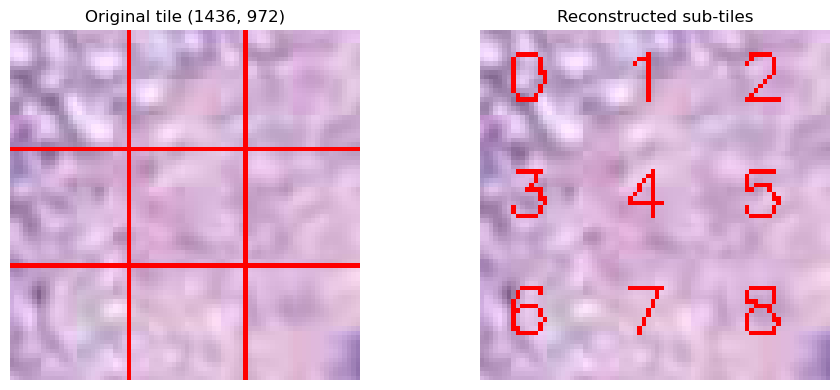

In [35]:
import random

# 隨機抽一筆資料（從全體 tiles 中）
i = random.randint(0, len(test_subtiles) - 1)

# 取對應的 sub-tiles 與 label
subtiles = test_subtiles[i]
label_tiles = test_labels[i]
slide_id, x, y = test_meta_info[i]  # 👈 slide 來源、spot 座標

with h5py.File('./elucidata_ai_challenge_data.h5', 'r') as h5file:
    test_images = h5file['images/Test']
    image = test_images[slide_id][()]
    
# 找原始 label（可選）
row_match = test_spot_table[(test_spot_table['x'] == x) & (test_spot_table['y'] == y)]

if len(row_match) == 0:
    print("⚠️ 找不到對應的 spot")
    label_gt = label_tiles  # fallback
else:
    label_gt = row_match.iloc[0].iloc[2:].values.astype(np.float32)

# 執行視覺化比對
print(f"Slides: {slide_id}")
compare_tile_and_label_visuals(image, x, y, subtiles)


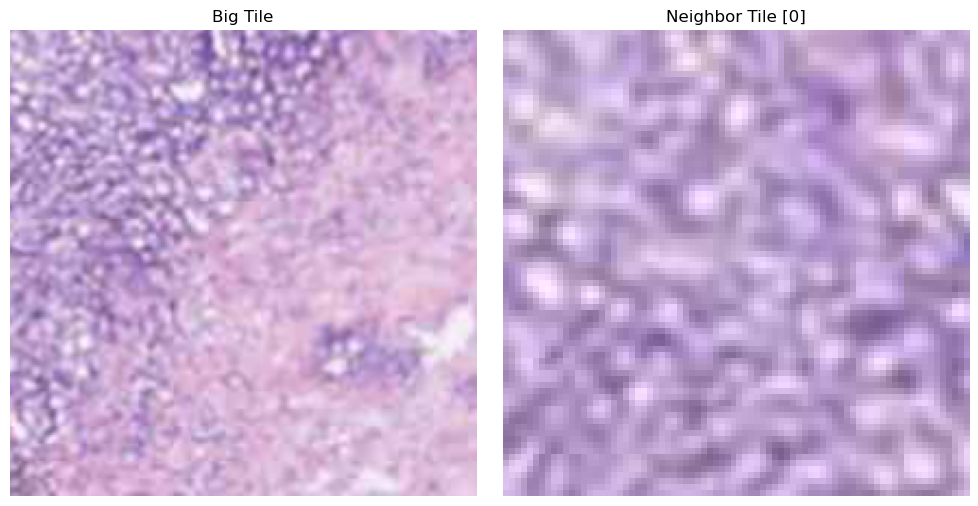

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 左邊是大 tile
tile = extract_tile(image, x, y, tile_size=tile_size + stride*2)
axes[0].imshow(tile)
axes[0].set_title("Big Tile")
axes[0].axis("off")

# 右邊是某個 neighbor tile
negihbor_num = 0
neighbor_tile = test_neighbor_tiles[i][negihbor_num]
axes[1].imshow(neighbor_tile)
axes[1].set_title(f"Neighbor Tile [{negihbor_num}]")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
## Make sure I have all the data     

print(f"Total number of spots across all slides: {len(test_spot_table)}")

print(f"The spots in our preprocessing datasets: {len(test_tiles)}")

Total number of spots across all slides: 2088
The spots in our preprocessing datasets: 2088


In [37]:
torch.save({
    'tiles': test_tiles,
    'subtiles': test_subtiles,
    'neighbor_tiles': test_neighbor_tiles,
    'labels': test_labels,
    'meta_info': test_meta_info
}, "test_dataset.pt")